## 1. Business Understanding
##### Q1: Is there any special pattern of 'busy' season where occupancy rate is significantly higher than usual?
##### Q2: does this 'busy' season pattern different among different areas of the city?
##### Q3: Where's the most expensive area?

In [192]:
import pandas as pd
import numpy as np
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#others
from tqdm import tqdm

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

## 2. Get Data

In [193]:
calendar = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')
# reviews = pd.read_csv('reviews.csv')

Quickly check the data quailty

In [199]:
def get_null_pctg(df):
    """
    Print the percentage of null appear in each column of dataframe.
    """
    for col in df.columns:
        pctg = round(df[col].isnull().sum()/df.shape[0]*100,2)
        print(f'The pecentage of null in column {col} is {pctg}%')

In [200]:
get_null_pctg(calendar)

The pecentage of null in column listing_id is 0.0%
The pecentage of null in column date is 0.0%
The pecentage of null in column available is 0.0%
The pecentage of null in column price is 50.87%


In [201]:
get_null_pctg(listing)

The pecentage of null in column id is 0.0%
The pecentage of null in column listing_url is 0.0%
The pecentage of null in column scrape_id is 0.0%
The pecentage of null in column last_scraped is 0.0%
The pecentage of null in column name is 0.0%
The pecentage of null in column summary is 3.99%
The pecentage of null in column space is 29.48%
The pecentage of null in column description is 0.0%
The pecentage of null in column experiences_offered is 0.0%
The pecentage of null in column neighborhood_overview is 39.47%
The pecentage of null in column notes is 55.09%
The pecentage of null in column transit is 35.98%
The pecentage of null in column access is 41.53%
The pecentage of null in column interaction is 43.35%
The pecentage of null in column house_rules is 33.25%
The pecentage of null in column thumbnail_url is 16.71%
The pecentage of null in column medium_url is 16.71%
The pecentage of null in column picture_url is 0.0%
The pecentage of null in column xl_picture_url is 16.71%
The pecenta

## 3. Answer each question by analyzing the data

##### Q1: Is there any special pattern of 'busy' season where occupancy rate is significantly higher than usual?

First, we parse the date(string) into more detailed features such as year, month and if that day is a weekend.

In [204]:
calendar['datetime'] = calendar['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
calendar['year-month'] = calendar['date'].apply(lambda x: x[0:7])

#Monday -> 0; Sunday -> 6
calendar['weekday'] = calendar['datetime'].apply(lambda x: x.weekday())
calendar['year'] = calendar['datetime'].apply(lambda x: x.year)
calendar['month'] = calendar['datetime'].apply(lambda x: x.month)
calendar['if_weekends'] = calendar['weekday'].apply(lambda x: 1 if x==5 or x==6 else 0)

calendar['if_booked'] = calendar['available'].map({'f':1,'t':0})

In [205]:
def get_agg_plot(df, x, y, hue):
    """
    Input: 
        df: The dataframe containing the data to plot, before aggregation
        x: feature for x axis
        y: feature for y axis
        hue: hue for the plot
    Output:
        agg: the aggregated dataframe containing only interested columns
        plot: a lineplot
    """
    group = df[[x,y,hue]].groupby([x,hue])
    agg = group.aggregate({y:pd.Series.mean})
    agg = agg.reset_index()

    sns.lineplot(data=agg,
                 x=x, 
                y=y, 
                hue=hue, 
                legend='full')

    # add title
    plt.title(f'Overall Book Rate By {x}')

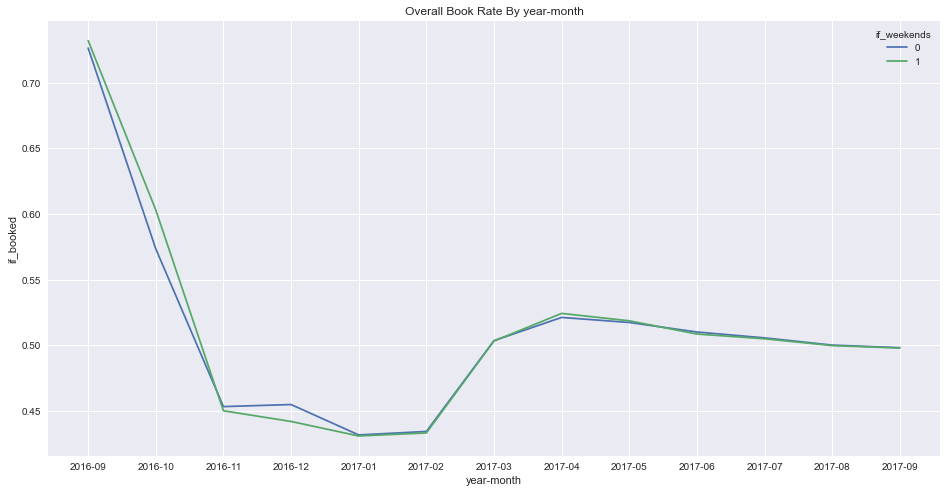

In [206]:
# check the booking rate by year-month
get_agg_plot(calendar, 'year-month','if_booked','if_weekends')

We can also check the plot by each week rather than each month:

In [207]:
#add 'week_num' feature first
calendar['week_num']=calendar['datetime'].apply(lambda x: x.isocalendar().week)

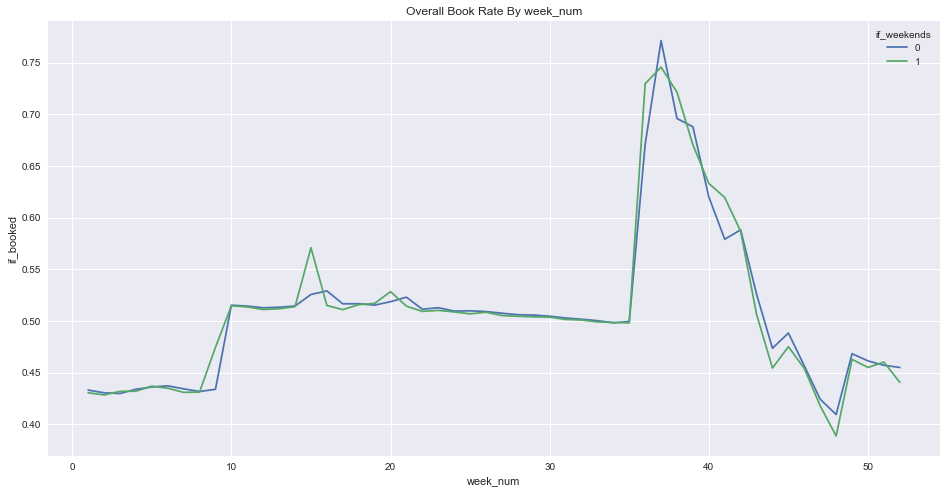

In [208]:
get_agg_plot(calendar, 'week_num','if_booked','if_weekends')

##### Answer for Q1: We see that in both data granularity, the booking rate do not increase consistently during weekends.

##### Q2: does this 'busy' season pattern different among different areas of the city?

Only take columns that we possibly need. Note that from the data quality check we did before, we know 'price' has 0.00% missing, and 'neighborhood' has 15.5% missing.  

In [209]:
listing_basic = listing[['id','zipcode','price','city','neighbourhood','square_feet']]

Merge the property information to its calendar data

In [219]:
calendar.drop(columns=['price'],inplace=True)
cal_list = calendar.merge(listing_basic, left_on='listing_id',right_on='id', how='left')

First, we need to drop those data with missing 'neighborhoods'. Since the missing rate is 15%, it's acceptable to drop them.

In [220]:
cal_list.dropna(subset=['neighbourhood'], inplace=True)

To see if differnet neighborhoods are 'same busy' from each other, we can look up the booking rate of each neighbourhood over the 12 months.

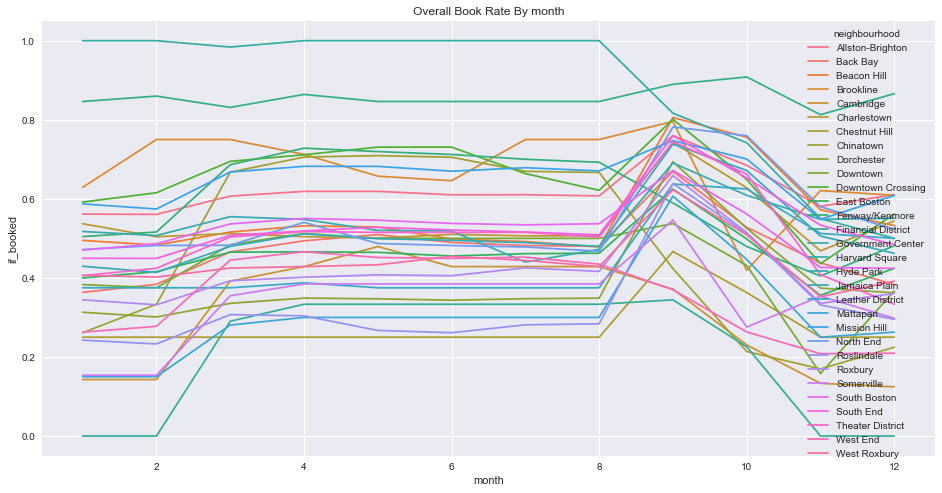

In [221]:
get_agg_plot(cal_list, 'month','if_booked','neighbourhood')

We see that there are actually 35 neighbourhoods and too many to show them all. We only show the top 10 neightborhoods

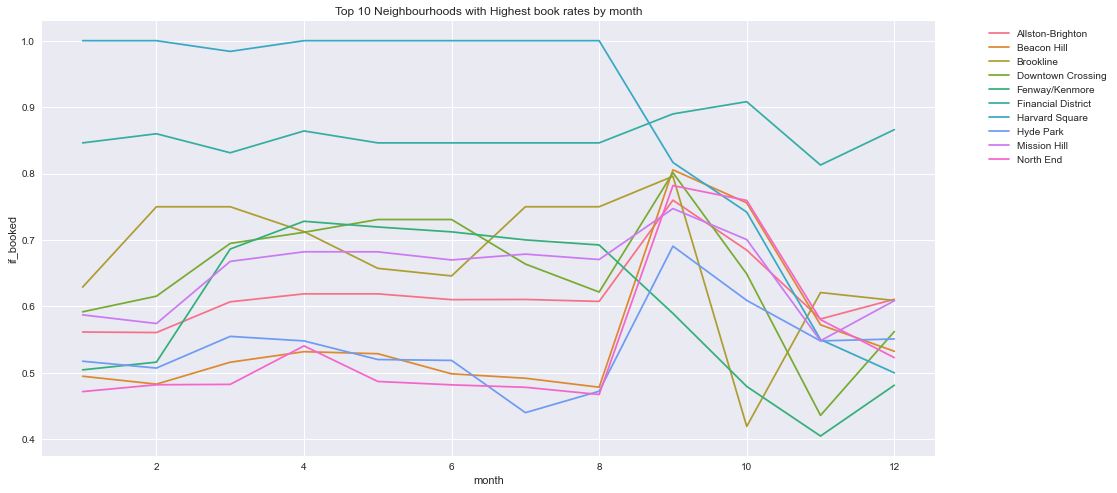

In [222]:
group = cal_list[['if_booked','month','neighbourhood']].groupby(['month','neighbourhood'])
agg = group.aggregate({'if_booked':pd.Series.mean})
agg = agg.reset_index()

top_10_n = agg.groupby('neighbourhood').aggregate({'if_booked': pd.Series.mean}).sort_values('if_booked', ascending=False)[0:10].index
top_10_data = agg[agg.neighbourhood.isin(top_10_n)]

palette = sns.color_palette('husl', 10)
sns.lineplot(data=top_10_data,
             x='month', 
             y='if_booked', 
             hue='neighbourhood',
             palette=palette, 
             legend='full')

# add title
plt.title('Top 10 Neighbourhoods with Highest book rates by month')
# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

We can see that  different neighbourhoods do not share the same pattern of 'busy' season. In Sep, most of the areas have spike in book rate while 'harvard Square' experienced a drop. Likewise, In Dec, it drops while most of the other neightbourhoods experienced a spike. 

## Q3: Where's the most expensive area?

'price' column: cast string object to float

In [223]:
cal_list_price_int = cal_list.price.map(lambda x: x.replace('$','').replace(',',''), na_action ='ignore')
cal_list['price'] = cal_list_price_int.astype(float)

Also, we check the top 10 expensive neightborhoods, and see their average price (by month) over the past 12 months

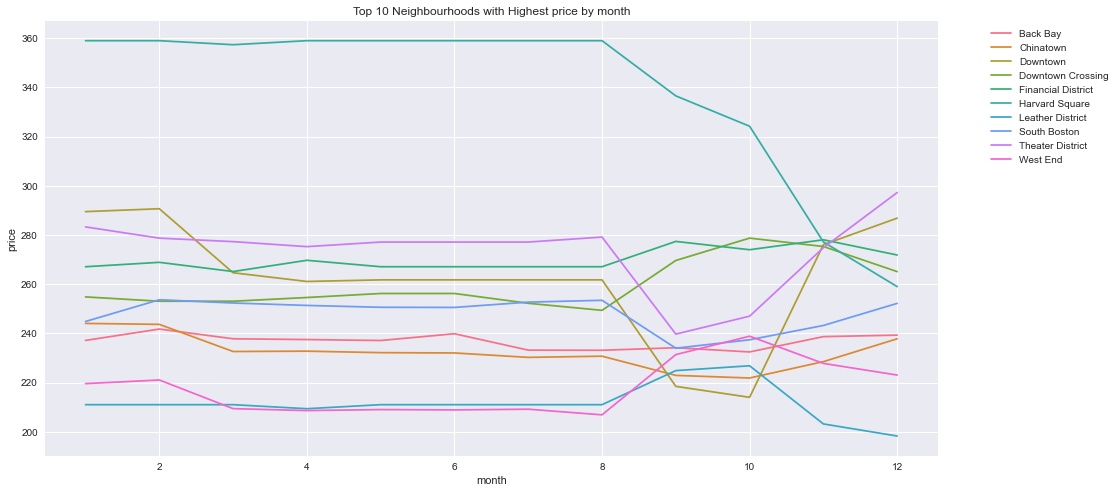

In [224]:
cond = cal_list.if_booked==1
group = cal_list[cond][['price','month','neighbourhood']].groupby(['month','neighbourhood'])
agg = group.aggregate({'price':pd.Series.mean})
agg = agg.reset_index()

top_10_n = agg.groupby('neighbourhood').aggregate({'price': pd.Series.mean}).sort_values('price', ascending=False)[0:10].index
top_10_data = agg[agg.neighbourhood.isin(top_10_n)]

palette = sns.color_palette('husl', 10)
sns.lineplot(data=top_10_data,
             x='month', 
             y='price', 
             hue='neighbourhood',
             palette=palette, 
             legend='full')

# add title
plt.title('Top 10 Neighbourhoods with Highest price by month')
# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

We can see that Harvard Square has an average price that is much higher than other areas.

## 4. Conclusion
There's no clear sign that weekends has higher booking rate. However, there are few 'special weekends' we can see spike of booking rate during weekends. The busy pattern is not the same for all neighborhoods, although most of them share similar patterns. The most expensive area is Harvard Square. 